In [88]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [89]:
from tensorflow.keras.models import load_model
model = load_model(r"mera_Unet_flood_model.keras")

In [90]:
import cv2
import numpy as np

test_image_path = r"C:\Users\nishi\Downloads\Dubai-Floods-Seen-From-Space-768x768.jpg"
test_image = cv2.imread(test_image_path)
test_image = cv2.resize(test_image, (256, 256))
test_image = test_image / 255.0

# Create dummy hydro and DEM inputs
dummy_input = np.zeros_like(test_image)

# Concatenate to simulate the full input (9 channels)
full_input = np.concatenate([test_image, dummy_input, dummy_input], axis=-1)  # shape: (256, 256, 9)
full_input = np.expand_dims(full_input, axis=0)  # shape: (1, 256, 256, 9)

# Predict
predicted_mask = model.predict(full_input)
predicted_mask = predicted_mask.squeeze()

# Calculate coverage
flood_area = np.mean(predicted_mask)
flood_area_coverage = ((flood_area * 100)-1)*100
flooded = flood_area_coverage/2

flood_area = flood_area*100
print(f"Estimated flood coverage: {flood_area:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
Estimated flood coverage: 11.87%


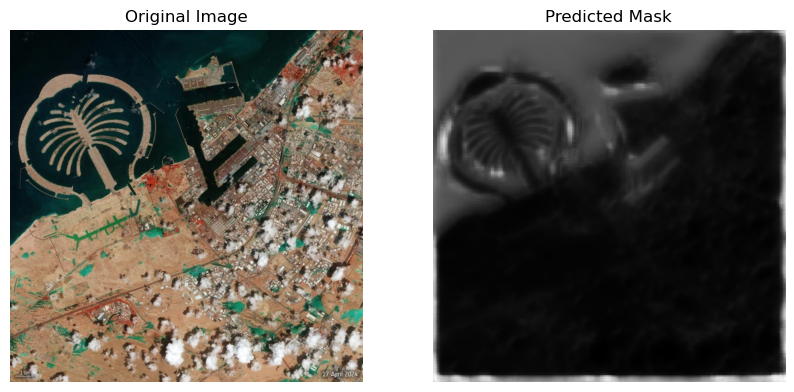

Flooded Area Coverage: 11.87%


In [91]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")
plt.show()
print(f"Flooded Area Coverage: {flood_area:.2f}%")

In [92]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model

class FloodModelWrapper:
    def __init__(self, model):
        self.model = load_model(model)

    def preprocess_input(self, rgb_image_path):
        # Load and preprocess the RGB image
        image = cv2.imread(rgb_image_path)
        image = cv2.resize(image, (256, 256))
        image = image / 255.0  # Normalize
        assert image.shape == (256, 256, 3), f"Invalid shape: {image.shape}"

        # Create dummy hydro and DEM channels
        dummy_hydro = np.zeros_like(image)
        dummy_dem = np.zeros_like(image)

        # Stack to make (256, 256, 9)
        full_input = np.concatenate([dummy_hydro, dummy_dem, image], axis=-1)
        full_input = np.expand_dims(full_input, axis=0)  # Add batch dimension
        return full_input

    def predict(self, rgb_image_path):
        input_tensor = self.preprocess_input(rgb_image_path)
        prediction = self.model.predict(input_tensor)
        return prediction.squeeze()  # Remove batch dimension

# Usage
model_wrapper = FloodModelWrapper(r"mera_Unet_flood_model.keras")
mask = model_wrapper.predict(r"C:\Users\nishi\Downloads\Dubai-Floods-Seen-From-Space-768x768.jpg")
flood_area = np.mean(mask)
flood_area_coverage = ((flood_area * 100)-1)*100
flooded = flood_area_coverage/2

flood_area = flood_area*100
print(f"Estimated flood coverage: {flood_area:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Estimated flood coverage: 15.58%


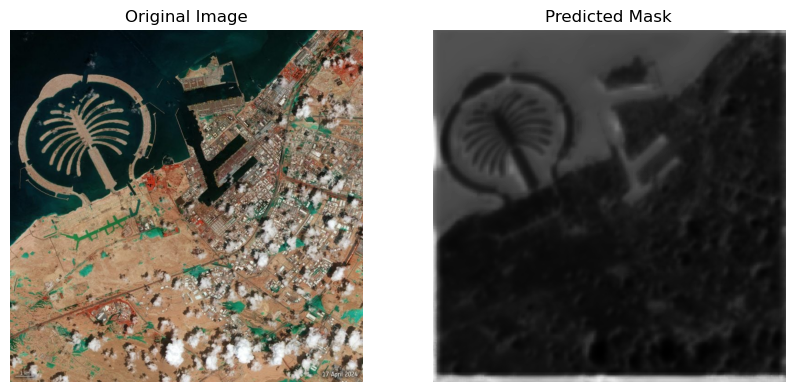

Flooded Area Coverage: 15.58%


In [93]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")
plt.show()
print(f"Flooded Area Coverage: {flood_area:.2f}%")

In [81]:
# `mask` is output from model.predict(), shape: (256, 256)
flood_coverage = np.mean(mask) * 100  # Convert to percentage
print(f"Estimated flood coverage: {flood_coverage:.2f}%")

Estimated flood coverage: 15.58%


In [74]:
threshold = 0.18
binary_mask = (mask > threshold).astype(np.uint8)
flood_coverage = np.mean(binary_mask) * 100
print(f"Estimated flood coverage (binary): {flood_coverage:.2f}%")

Estimated flood coverage (binary): 13.23%


In [75]:
# Save grayscale mask (raw prediction)
cv2.imwrite("predicted_flood_mask_raw.png", (mask * 255).astype(np.uint8))

# Save binary mask
cv2.imwrite("predicted_flood_mask_binary.png", binary_mask * 255)

True